---
title: "Machine Learning Notes V: Support Vector Machines"
author: "Alejandro Pérez Sanjuán"
date: 2024-08-24
categories: [machine learning, python, support vector machine]
format: html
---

Notes for myself about support vector machines and how to implement them from scratch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import ClassifierMixin

## 1. Introduction

Support vector machines (SVM) are a supervised algorithm than can be used for both regression and classification. The main ideas are better understood using a classification problem as an example.

Suppose we want to build a model that has to correctly identify the classes in a binary classification problem. SVM draws a hyperplane between the 2 sets of points in space that is able to perform this classification task. We study in the next sections how to construct an optimal hyperplane.

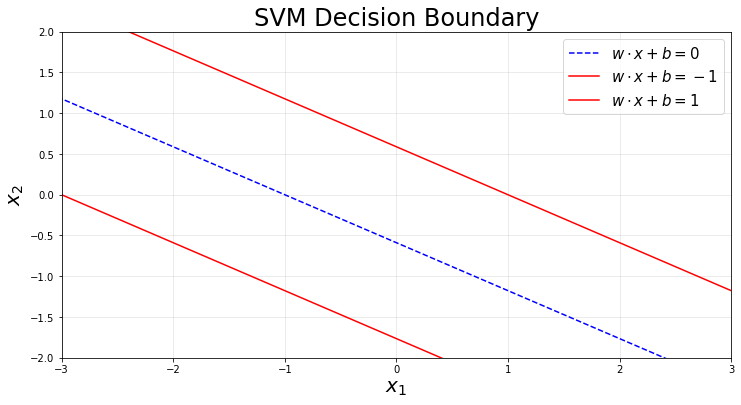

In [2]:
def plot_svm():
    x1 = np.linspace(-5, 5, 100)
    w = np.array([-0.5, -0.85])
    b = -0.5

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    for i, offset in enumerate([0, -1, 1]):
        x2 = -(w[0] * x1 + b + offset) / w[1]

        if i == 0:
            ax.plot(x1, x2, label=f'$w \cdot x + b = {offset}$', color='blue', linestyle="--")
        else:
            ax.plot(x1, x2, label=f'$w \cdot x + b = {offset}$', color='red')
    
    ax.grid(True, alpha=.3)
    ax.set_xlabel(r'$x_1$', fontsize=20)
    ax.set_ylabel(r'$x_2$', fontsize=20)
    ax.set_title('SVM Decision Boundary', fontsize=24)
    ax.set_xlim([-3, 3])
    ax.set_ylim([-2, 2])
    ax.legend(fontsize=15)

plot_svm()

### 1.1. Notation

In this section we briefly cover the notation used in this post for SVMs. A decision boundary is given by

$$
x_{i} \cdot w + b = 0 \ \text{for some data point $i$},
$$

where $x_{i} \in \mathbb{R}^{1,p}$ is the $i$-th row of a matrix of features $X \in \mathbb{R}^{n,p}$ and represents a single data point. $n$ and $p$ are the number of samples and features respectively. The parameter $b\in \mathbb{R}^{1}$ is the intercept, which is convenient to separate from the column-vector of coefficients $w \in \mathbb{R}^{p,1}$.

**DISCLAIMER:** the notation is used somewhat loosely during this post.

### 1.2. Hard margin SVM

When the data is linearly separable we can construct a margin defined by 2 hyperplanes that maximizes the distance between the 2 sets of data. In fact, SVM are sometimes called *maximum margin separating hyperplane*. These 2 hyperplanes are defined by the following equations:

$$
x_{i} \cdot w + b = 1; \ \text{every point in or above this line is classified as 1}, \\
x_{i} \cdot w + b = -1; \ \text{every point in or below this line is classified as -1},
$$

Now, the distance between the parallel lines $ax + by + c_1 = 0$ and $ax + by + c_2 = 0$ (hyperplanes in 2D) [is defined as](https://www.cuemath.com/geometry/distance-between-two-lines/)

$$
d = \dfrac{|c_2 - c_1|}{\sqrt{a^2 + b^2}}.
$$

To find the margin $m$ (distance between the hyperplanes) we can plug the expressions defined above

$$
m = \dfrac{1 - (-1)}{||w||} = \dfrac{2}{||w||},
$$

which is precisely the magnitude we want to maximize. Note that this equivalent to minimizing $||w||$.

#### 1.2.1. Optimization problem

The hard margin SVM problem can be formulated as an optimization problem:

$$
\text{min}_{||w||} \quad \dfrac{2}{||w||} \\
\textrm{s.t.} \quad x_{i} \cdot w + b \geq 1 \\
\qquad x_{i} \cdot w + b \leq -1
$$

Note that the constraints can be expressed in a single line:

$$
\min_{||w||} \quad \dfrac{2}{||w||} \\
\textrm{s.t.} \quad y_{i} (x_{i} \cdot w + b) \geq 1,
$$

where $y_{i}$ is the corresponding label to the point $x_{i}$.

### 1.3. Soft margin SVM

The hard margin SVM does not allow any points inside the margin, so if the data is not linearly separable the constrains cannot be met and thus, a solution does not exist. A way to solve this issue is by allowing points inside the margin but for every point that is either on the wrong side of the hyperplane or inside the margin we add a penalty to the loss function. The penaly is proportional to the distance between the point and the hyperplane that this point belongs to.

The Hinge loss function encapsulates this way of penalizing points at wrong locations:

$$
\max (0, 1 - y_{i}(x_{i} \cdot w + b)).
$$

We add the hinge-loss function to our objective function $J$ such that we minimize the average Hinge loss and also $||w||$:

$$
J(w,b) = ||w|| + C \cdot \dfrac{1}{n} \sum_{i=0}^{n} \max (0, 1 - y_{i}(x_{i} \cdot w + b)).
$$

$C$ is a regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error. Large values of $C$ will generate closer a behaviour to the one performed by a hard margin SVM. One last trick: we can square the norm of $w$ to make the function convex and ease the optimization

$$
J(w, b) = ||w||^2 + C \cdot \dfrac{1}{n} \sum_{i=0}^{n} \max (0, 1 - y_{i}(x_{i} \cdot w + b)).
$$

Notice that if $y_{i}(x_{i} \cdot w + b) \geq 1$, the $J$ is

$$
J(w,b) = ||w||^2.
$$

Otherwise, the loss function takes the form

$$
J(w,b) = ||w||^2 + C \cdot \dfrac{1}{n} \sum_{i=0}^{n}1 - y_{i}(x_{i} \cdot w + b).
$$

#### 1.3.1. (Sub)Gradient descent

The Hinge loss function is not differentiable but has a sub-gradient with respect to its parameters $w$ and $b$. We need to account for the value of $y_{i}(x_{i} \cdot w + b)$ to obtain the derivatives.

Whenever we satisfy $y_{i}(x_{i} \cdot w + b) \geq 1$

$$
\dfrac{
    \partial J (w,b)
}{
    \partial w
} = 2 w, \qquad \dfrac{
    \partial J (w,b)
}{
    \partial b
} = 0
$$

Otherwise

$$
\dfrac{
    \partial J (w,b)
}{
    \partial w
} = 2 w - C \dfrac{1}{n} \sum_{i=0}^{n} y_{i} x_{i}, \qquad \dfrac{
    \partial J (w,b)
}{
    \partial b
} = C \dfrac{1}{n} \sum_{i=0}^{n} -y_{i}.
$$

We will leave the theory here and later we will come back in this or another post to explain the dual SVM and the Kernel trick.

## 2. Coding a SVM from scratch

In [3]:
class SoftSVMClassifier(ClassifierMixin):
    def __init__(
        self,
        l_rate=1e-3,
        batch_size=32,
        n_epochs=1_000,
        C=0.01,
    ):
        self.l_rate = l_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.C = C

        # attributes
        self.w_coeff_ = None
        self.b_coeff_ = None
        self.loss = []

    def fit(self, X, y):
        _y = np.where(y <= 0, -1, 1)

        n_samples, n_features = X.shape
        w_coeff = np.zeros(n_features)
        b_coeff = 0
        C = self.C

        for _ in range(self.n_epochs):
            for i in range(0, n_samples, self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = _y[i:i + self.batch_size]

                # Gradient initialization
                dJ_dW = np.zeros_like(w_coeff)
                dJ_db = 0

                for x_i, y_i in zip(X_batch, y_batch):
                    hinge = y_i * (x_i @ w_coeff + b_coeff)
                    if hinge >= 1:
                        dJ_dW += 2 * w_coeff
                        dJ_db += 0
                    else:
                        dJ_dW += 2 * w_coeff + C * (-y_i * x_i)
                        dJ_db += C * (-y_i)

                w_coeff -= self.l_rate * dJ_dW / self.batch_size
                b_coeff -= self.l_rate * dJ_db / self.batch_size

        self.w_coeff_ = w_coeff
        self.b_coeff_ = b_coeff

    def predict(self, X):
        w_coeff = self.w_coeff_
        b_coeff = self.b_coeff_

        y_pred = np.sign(X @ w_coeff + b_coeff)
        return y_pred

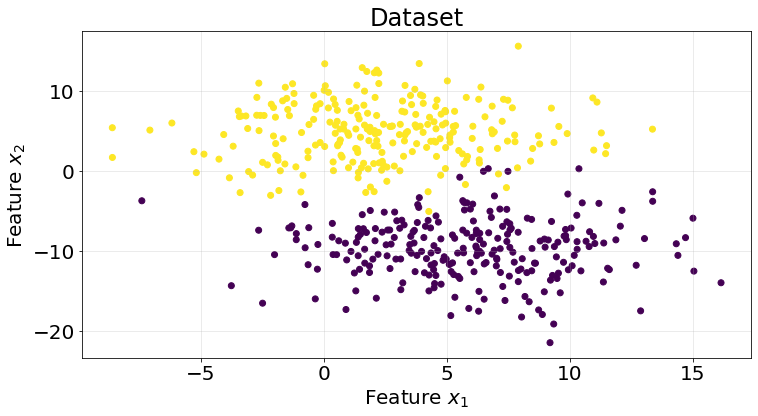

In [4]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, random_state=10, cluster_std=4)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X[:, 0], X[:, 1], c=y)
ax.grid(True, alpha=.3)
ax.set_title("Dataset", fontsize=24)
ax.set_xlabel("Feature $x_{1}$", fontsize=20)
ax.set_ylabel("Feature $x_{2}$", fontsize=20)
ax.tick_params(labelsize=20)

In [5]:
kf = KFold(n_splits=5)

roc_scores = []
for train_idx, test_idx in kf.split(X):
    model = SoftSVMClassifier(n_epochs=5_000, batch_size=32)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred = np.where(y_pred <= 0, 0, y_pred)

    score = roc_auc_score(y_true=y_test, y_score=y_pred)
    roc_scores.append(score)

An average of 0.94 on classification tasks for this particular dataset.

In [6]:
np.mean(roc_scores)

0.941089620821495

## 3. Strengths and Weaknesses

A summary of strenghts and weaknesses of this model.

### Pros

* Versatile.
* Not many params to optimize.
* With the Kernel trick, it can be a really good model for high non-linear data.

### Cons

* Computationally intensive
* Requires careful tuning
* Not suited for large-scale datasets
* Sensitive to parameter choice.
* Kind of hard to understand.